# Fine-Tuning and Guidance

In this notebook, we will explore two primary methods for modifying existing diffusion models:

* Through **fine-tuning**, we'll retrain existing models on new data to alter the type of output they generate.
* Via **guidance**, we'll utilize an existing model and direct the generation process during inference for additional control.

## Setup and Imports

In order to save our fine-tuned models to the Hugging Face Hub, it's necessary to log in with a token that grants write access. The code provided below will request this token and direct us to the corresponding tokens page within our account. Additionally, for utilizing the training script to log samples during the model training process, a Weights and Biases account is required.

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Loading A Pre-Trained Pipeline

We load an existing pipeline

In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  0%|          | 0/1000 [00:00<?, ?it/s]

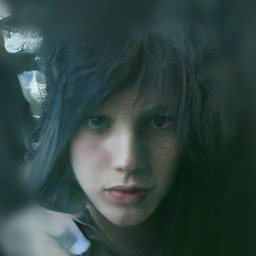

In [6]:
images = image_pipe().images
images[0]

## Faster Sampling with DDIM


In each iteration, the model receives a noisy input and is tasked with predicting the noise, providing an estimation of what the fully denoised image could resemble. Initially, these predictions may not be very accurate, prompting us to divide the process into numerous steps. However, recent research has indicated that employing over 1000 steps is unnecessary, and there has been a surge in investigations on achieving high-quality samples with as few steps as possible.

Within the Diffusers library, the responsibility of managing these **sampling methods lies with a scheduler**. This scheduler executes each update through the `step()` function. The process of generating an image starts with random noise represented as $x$. Subsequently, for each timestep in the noise schedule defined by the scheduler, we provide the noisy input $x$ to the model. The resulting prediction is then passed to the `step()` function. This function returns an output with a `prev_sample` attribute. It's termed "previous" because the progression is "backward" in time, transitioning from high noise to low noise, which is the reverse of the forward diffusion process.

In [7]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

You can see that this model does 40 steps total, each jumping the equivalent of 25 steps of the original 1000-step schedule:

In [8]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

We create 4 random images and run through the sampling loop, viewing both the current $x$ and the predicted denoised version as the process progresses:

0it [00:00, ?it/s]

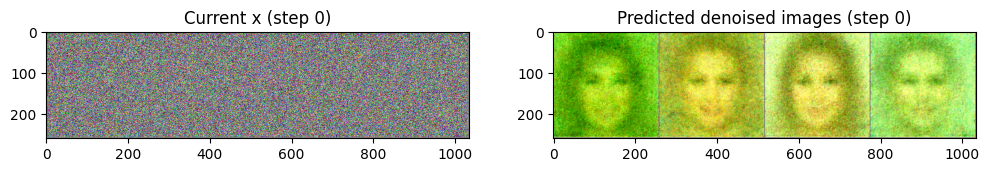

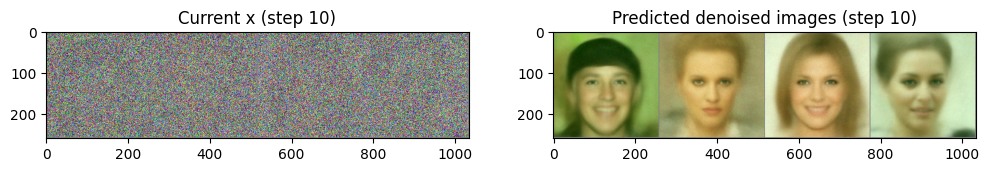

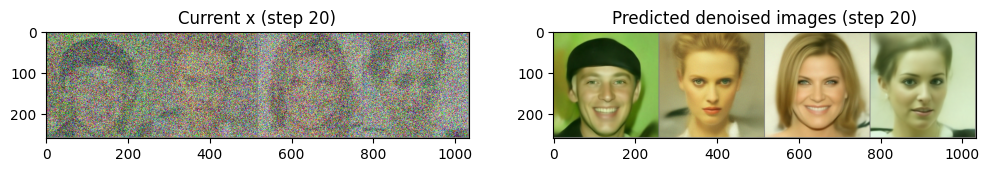

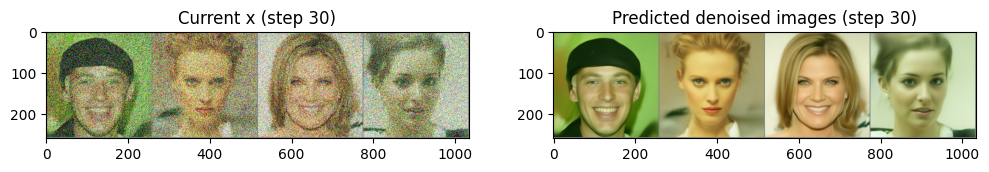

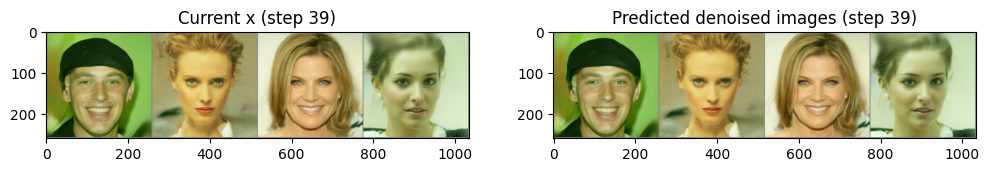

In [9]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [10]:
# ??scheduler.step

  0%|          | 0/40 [00:00<?, ?it/s]

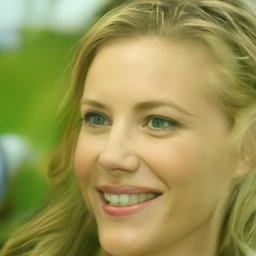

In [11]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

Hence, we can get samples in a much faster time now